Checking for archives to unpack in 'cubemaps'...
Unpacking process finished.
Selected random cubemap: '0'
Showing a PyVista plot with the random cubemap as background.


/home/dima/miniconda3/envs/aiijcenv/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


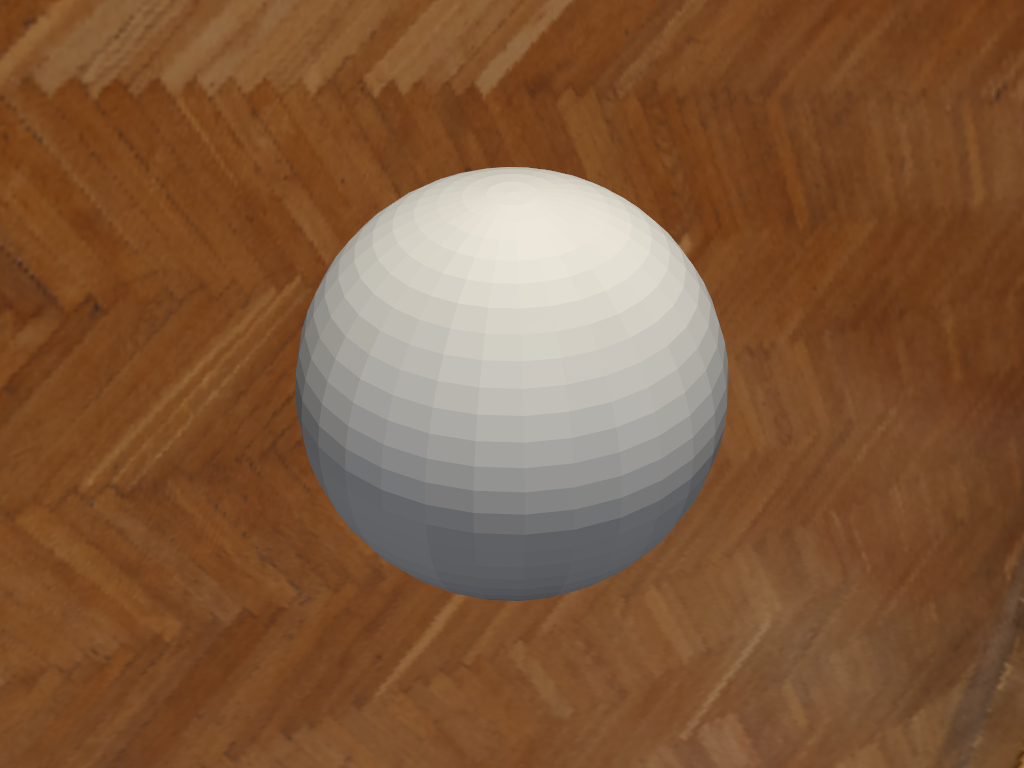

In [10]:
import os
import zipfile
import shutil
import re
import random

# Try to import pyvista, but don't fail if it's not installed.
# The error will be raised only when get_random_pyvista_cubemap is called.
try:
    import pyvista as pv
except ImportError:
    pv = None

def unpack_cubemaps(data_dir='cubemaps'):
    """
    Unpacks .zip archives from a directory into structured subfolders.

    Each archive is unpacked into a subdirectory named after a number 'n'.
    The files inside are renamed according to the pattern: n_[pos/neg][x/y/z].png.
    This function is idempotent, meaning it will not re-unpack archives if the
    target directories already exist.

    Args:
        data_dir (str): The path to the directory containing both the .zip files
                        and where the output folders will be created.
    """
    print(f"Checking for archives to unpack in '{data_dir}'...")

    # Ensure the base directory exists
    if not os.path.exists(data_dir):
        print(f"Directory '{data_dir}' not found. Creating it.")
        os.makedirs(data_dir)

    # --- Main loop to iterate through files in the directory ---
    for filename in os.listdir(data_dir):
        if not filename.endswith('.zip'):
            continue

        # --- Determine the number 'n' from the archive's filename ---
        if filename == 'Standard-Cube-Map.zip':
            n = 0
        else:
            # Use a regular expression to find the number in parentheses, e.g., (1), (12)
            match = re.search(r'\((\d+)\)', filename)
            if match:
                n = int(match.group(1))
            else:
                continue # Skip .zip files that don't match the expected naming pattern

        # --- Create the target directory for the current cubemap ---
        new_dir_path = os.path.join(data_dir, str(n))
        
        # --- Unpack only if the directory doesn't already exist ---
        if os.path.exists(new_dir_path):
            # print(f"Directory '{new_dir_path}' already exists. Skipping unpack.")
            continue
        
        print(f"Unpacking '{filename}' to '{new_dir_path}'...")
        os.makedirs(new_dir_path)

        # --- Unpack and rename files ---
        zip_path = os.path.join(data_dir, filename)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for member in zip_ref.namelist():
                original_name = os.path.basename(member)

                # Skip directories or non-PNG files within the archive
                if not original_name or not original_name.endswith('.png'):
                    continue
                
                # Logic to determine the new filename
                prefix_char = original_name[0]  # 'n' or 'p'
                axis_char = original_name[1]    # 'x', 'y', or 'z'
                side = 'neg' if prefix_char == 'n' else 'pos'
                
                # Format the new name: e.g., "2_posx.png"
                new_name = f"{n}_{side}{axis_char}.png"
                target_path = os.path.join(new_dir_path, new_name)

                # Extract the file and save it with the new name
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    shutil.copyfileobj(source, target)
    
    print("Unpacking process finished.")


def get_random_pyvista_cubemap(data_dir='cubemaps'):
    """
    Selects a random cubemap from the data directory and returns it as a PyVista object.

    This function first ensures all cubemaps are unpacked. Then, it randomly
    chooses one of the numbered subdirectories and loads the corresponding
    cubemap textures using pyvista.

    Args:
        data_dir (str): The directory containing the numbered cubemap folders.

    Returns:
        pyvista.Texture: A PyVista cubemap texture object, or None if no
                         cubemaps are found or PyVista is not installed.
    """
    if pv is None:
        print("Error: PyVista library is not installed. Please install it with 'pip install pyvista'")
        return None

    # Step 1: Ensure all archives are unpacked into their respective folders.
    unpack_cubemaps(data_dir)

    # Step 2: Find all valid, numbered cubemap directories.
    try:
        subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d.isdigit()]
    except FileNotFoundError:
        print(f"Error: Data directory '{data_dir}' not found.")
        return None

    if not subdirs:
        print(f"Error: No numbered cubemap directories found in '{data_dir}'.")
        return None

    # Step 3: Choose a random cubemap directory.
    random_n = random.choice(subdirs)
    print(f"Selected random cubemap: '{random_n}'")

    # Step 4: Define the parameters for PyVista.
    # The path to the directory containing the 6 images.
    cubemap_path = os.path.join(data_dir, random_n)
    # The prefix for the image files, e.g., "2_". PyVista will append "posx", "negy", etc.
    cubemap_prefix = f"{random_n}_"
    # The file extension.
    cubemap_ext = ".png"

    # Step 5: Create and return the PyVista cubemap object.
    return pv.cubemap(cubemap_path, cubemap_prefix, cubemap_ext)

# --- Example Usage ---
if __name__ == '__main__':
    # Define the directory where your 'Standard-Cube-Map.zip', 'Cube-Map(1).zip', etc. are located.
    CUBEMAPS_DIRECTORY = 'cubemaps'

    # Get a random cubemap.
    random_cubemap = get_random_pyvista_cubemap(CUBEMAPS_DIRECTORY)

    if random_cubemap:
        # If the cubemap was loaded successfully, you can use it in a PyVista plot.
        # For example, let's create a sphere and add the cubemap as a background.
        
        # Ensure PyVista is installed for this part to run
        if pv:
            # Create a plotter
            plotter = pv.Plotter()
            
            # Add a reflective sphere to the scene to showcase the cubemap
            sphere = pv.Sphere()
            plotter.add_mesh(sphere, color='white', metallic=1.0, roughness=0.1)
            
            # Add the cubemap as a background texture
            plotter.add_actor(random_cubemap.to_skybox())
            plotter.set_environment_texture(random_cubemap) # For reflections
            
            print("Showing a PyVista plot with the random cubemap as background.")
            plotter.show()
        else:
            print("Cannot display plot because PyVista is not installed.")

In [3]:
true_colors = ['#5d4b3b', '#3634af', '#799886', '#53463a', '#22150a', '#543c30', '#212021', '#72a18d', '#53403b', '#55453a', '#5478cc', '#373d5a', '#614439', '#13100a', '#585858', '#0a0604', '#4f87b0', '#3b6176', '#335746', '#577eae', '#3b412a', '#243551', '#6c6333', '#6c6964', '#322e2a', '#0b0b0b', '#624941', '#554e48', '#534a57', '#704636', '#1a0e09', '#513e27', '#513928', '#734e52', '#464e57', '#6c5c4a', '#58a5d2', '#6c4e3a', '#776831', '#66e9f8', '#76726c', '#54548b', '#38375f', '#404140', '#3d3933', '#76594c', '#3a3832', '#6a892c', '#353836', '#616261', '#060708', '#756c56', '#788f75', '#312c2e', '#5b9d84', '#616569', '#725d4f', '#413839', '#789888', '#7a763c', '#484848', '#4e4b49', '#41758f', '#5c5d60']

In [ ]:
import pyvista as pv
import numpy as np
import os
import random
import math

class STLRenderer:
    """
    A class to render STL files using a flexible configuration for randomization.
    Supports PBR, wireframe, and orthographic render modes with correct camera setups.
    """
    def __init__(self, config: dict):
        self.config = config
        self.cubemap_loaders = [get_random_pyvista_cubemap]
        print(f"Renderer initialized. Available modes: {config.get('render_modes', [])}")

    def generate_render(self, output_path: str, resolution: tuple[int, int],
                        mesh: pv.PolyData, render_params: dict):
        """
        Generates a single render based on a dictionary of parameters.
        """
        plotter = pv.Plotter(off_screen=True, window_size=resolution)
        
        if render_params.get('pbr', False):
            pass

        mesh.texture_map_to_plane(inplace=True)
        plotter.add_mesh(
            mesh, **render_params.get('mesh_style', {})
        )

        cubemap = render_params.get('cubemap_texture')
        if cubemap:
            plotter.add_actor(cubemap.to_skybox())
            plotter.set_environment_texture(cubemap)
        else:
            plotter.set_background(render_params.get('background_color'))
        
        if render_params.get('show_axes', False):
            plotter.add_axes()

        # --- KEY CHANGE: Set camera view based on mode ---
        view_preset = render_params.get('view_preset')
        if view_preset == 'isometric':
            plotter.view_isometric()
            plotter.enable_parallel_projection()
        else:
            plotter.camera_position = render_params.get('camera_position')

        plotter.screenshot(output_path, transparent_background=(render_params.get('background_color') is None and not cubemap))
        plotter.close()

    def generate_random_renders(self, stl_path: str, num_renders: int, resolution: tuple[int, int]):
        if not os.path.exists(stl_path):
            print(f"Error: STL file not found at {stl_path}"); return

        mesh = pv.read(stl_path)
        mesh.translate(-np.array(mesh.center), inplace=True)

        textures_dir = self.config['textures_dir']
        texture_files = [os.path.join(textures_dir, f) for f in os.listdir(textures_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(textures_dir) else []
        
        output_dir = self.config['output_dir']
        os.makedirs(output_dir, exist_ok=True)
        base_name = os.path.splitext(os.path.basename(stl_path))[0]
        
        print(f"\nGenerating {num_renders} random renders for {base_name}.stl...")

        for i in range(num_renders):
            render_mode = random.choice(self.config['render_modes'])
            params = {'pbr': True, 'mesh_style': {}}
            
            if render_mode == 'pbr':
                if random.choice([True, False]) and texture_files:
                    params['mesh_style']['texture'] = pv.read_texture(random.choice(texture_files))
                else:
                    params['mesh_style']['color'] = random.choice(self.config['object_colors'])
                
                params['mesh_style']['metallic'] = random.uniform(*self.config['pbr_metallic_range'])
                params['mesh_style']['roughness'] = random.uniform(*self.config['pbr_roughness_range'])
                
                if random.choice([True, False]):
                    params['cubemap_texture'] = get_random_pyvista_cubemap()
                else:
                    params['background_color'] = random.choice(self.config['background_options'])
                
                # For PBR mode, use random orbiting camera
                params['camera_position'] = get_random_camera_position(mesh, self.config)

            elif render_mode == 'wireframe':
                params['mesh_style'] = {
                    'style': 'wireframe',
                    'color': self.config['wireframe_color']
                }
                params['background_color'] = '#404040'
                # For Wireframe mode, also use random orbiting camera
                params['camera_position'] = get_random_camera_position(mesh, self.config)

            elif render_mode == 'orthographic':
                params['pbr'] = False
                params['mesh_style'] = {
                    'color': self.config['ortho_color'],
                    'show_edges': self.config['ortho_show_edges'],
                    'edge_color': self.config['ortho_edge_color']
                }
                params['background_color'] = self.config['ortho_bg_color']
                params['show_axes'] = True
                # For Ortho mode, use a fixed isometric view preset
                params['view_preset'] = 'isometric'
            
            output_filename = os.path.join(output_dir, f"{base_name}_{i + 1}_{render_mode}.png")

            self.generate_render(
                output_path=output_filename,
                resolution=resolution,
                mesh=mesh,
                render_params=params
            )
            print(f"  -> Saved {output_filename}")

def get_random_camera_position(mesh: pv.PolyData, config: dict) -> list:
    model_size = mesh.length
    distance = random.uniform(*config['camera_distance_range']) * model_size
    if distance < 1.0: distance = 1.0
    azimuth = random.uniform(0, 360)
    elevation = random.uniform(*config['camera_elevation_range'])
    elev_rad, azim_rad = math.radians(90 - elevation), math.radians(azimuth)
    x = distance * math.sin(elev_rad) * math.cos(azim_rad)
    y = distance * math.sin(elev_rad) * math.sin(azim_rad)
    z = distance * math.cos(elev_rad)
    return [(x, y, z), [0, 0, 0], [0, 0, 1]]

if __name__ == "__main__":
    RENDER_CONFIG = {
        "output_dir": "renders",
        "textures_dir": "textures",
        "render_modes": ['pbr', 'pbr', 'wireframe', 'orthographic'],
        "object_colors": ['#C0C0C0', '#A9A9A9', '#F5F5DC', '#DEB887', '#4682B4', '#90EE90'],
        "background_options": ["black", "grey", "#303030", None],
        "pbr_metallic_range": (0.0, 1.0),
        "pbr_roughness_range": (0.05, 0.9),
        "wireframe_color": "white",
        "ortho_color": "#5e5e5e",
        "ortho_bg_color": "#ffffff",
        "ortho_show_edges": True,
        "ortho_edge_color": "#404040",
        "camera_distance_range": (2.5, 4.0),
        "camera_elevation_range": (10, 80),
    }

    STL_FILE = "model.stl"
    NUM_RENDERS = 20
    RESOLUTION = (512, 512)

    if not os.path.exists(STL_FILE): pv.Cube().save(STL_FILE); print(f"Created sample file: {STL_FILE}")
    if not os.path.exists(RENDER_CONFIG['textures_dir']): os.makedirs(RENDER_CONFIG['textures_dir']); print(f"Created directory: {RENDER_CONFIG['textures_dir']}")

    renderer = STLRenderer(config=RENDER_CONFIG)
    renderer.generate_random_renders(
        stl_path=STL_FILE,
        num_renders=NUM_RENDERS,
        resolution=RESOLUTION,
    )
    print(f"\nSuccess! All renders saved in '{RENDER_CONFIG['output_dir']}'.")

Renderer initialized. Available modes: ['pbr', 'pbr', 'wireframe', 'orthographic']

Generating 20 random renders for model.stl...
  -> Saved renders/model_1_orthographic.png
  -> Saved renders/model_2_wireframe.png
  -> Saved renders/model_3_wireframe.png
  -> Saved renders/model_4_pbr.png
  -> Saved renders/model_5_orthographic.png
  -> Saved renders/model_6_orthographic.png
  -> Saved renders/model_7_pbr.png
  -> Saved renders/model_8_pbr.png
  -> Saved renders/model_9_pbr.png
  -> Saved renders/model_10_pbr.png
  -> Saved renders/model_11_wireframe.png
  -> Saved renders/model_12_pbr.png
  -> Saved renders/model_13_pbr.png
  -> Saved renders/model_14_wireframe.png
  -> Saved renders/model_15_pbr.png
  -> Saved renders/model_16_orthographic.png
  -> Saved renders/model_17_orthographic.png
  -> Saved renders/model_18_pbr.png
  -> Saved renders/model_19_orthographic.png
  -> Saved renders/model_20_pbr.png

Success! All renders saved in 'renders'.
